### Objetivo, poder identificar si el paciente tiene una patologia; Tuberculosis, covid 19 o bien si está sano, a traves de una imagen de rayos x.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import os
os.chdir("/content/drive/MyDrive/DATA2")
!ls

test  train  val


#### Librerias necesarias

In [2]:
import glob as gb 
import os
import sys 
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import random as rn 
import shutil 
import cv2
import tensorflow as tf 
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, GlobalMaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import regularizers, losses, metrics
from sklearn import metrics

### Activando GPU

In [12]:
print("Num GPU: ", len(tf.config.list_physical_devices("GPU")))
print(tf.test.is_gpu_available())
print(tf.test.is_built_with_cuda())

Num GPU:  1
True
True


### Obteniendo el directorio de los datos:

In [14]:
dir = '/content/drive/MyDrive' # Directorio principal
data_dir = os.path.join(dir, 'DATA2')

# Directorio con las imagenes de entrenamiento, prueba y validación
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
val_dir = os.path.join(data_dir, 'val')

# Carpetas de los diferentes tipos de datos, para train, test, validation:
#train
train_n_dir = os.path.join(train_dir, 'NORMAL')
train_c19_dir = os.path.join(train_dir, 'COVID19')
train_tb_dir = os.path.join(train_dir, 'TURBERCULOSIS')
train_pn_dir = os.path.join(train_dir, 'PNEUMONIA')

#prueba
test_n_dir = os.path.join(test_dir, 'NORMAL')
test_c19_dir = os.path.join(test_dir, 'COVID19')
test_tb_dir = os.path.join(test_dir, 'TURBERCULOSIS')
test_pn_dir = os.path.join(test_dir, 'PNEUMONIA')

# validacion
val_n_dir = os.path.join(val_dir, 'NORMAL')
val_c19_dir = os.path.join(val_dir, 'COVID19')
val_tb_dir = os.path.join(val_dir, 'TURBERCULOSIS')
val_pn_dir = os.path.join(val_dir, 'PNEUMONIA')


# Listando los nombres de los archivos para imagenes en las distintas carpetas, train, test, validation
# train
list_train_n = os.listdir(train_n_dir)
list_train_c19 = os.listdir(train_c19_dir)
list_train_tb = os.listdir(train_tb_dir)
list_train_pn = os.listdir(train_pn_dir)

#test
list_test_n = os.listdir(test_n_dir)
list_test_c19 = os.listdir(test_c19_dir)
list_test_tb = os.listdir(test_tb_dir)
list_test_pn = os.listdir(test_pn_dir)
#val
list_val_n = os.listdir(val_n_dir)
list_val_c19 = os.listdir(val_c19_dir)
list_val_tb = os.listdir(val_tb_dir)
list_val_pn = os.listdir(val_pn_dir)


### Visualizando la distribucion de las imagenes, cual es la cantidad que se tiene para cada conjunto de datos

,Porcentaje,Tipo de dato
0,0.211982,Normal
1,0.072716,Covid 19
2,0.102751,Tuberculosis
3,0.612551,Pneumonia


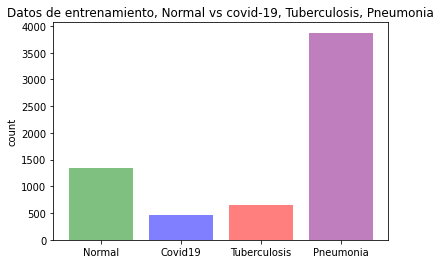

In [15]:
plt.bar([1, 2, 3, 4], np.array([len(list_train_n), len(list_train_c19), len(list_train_tb), len(list_train_pn)]), color=['green', 'blue', 'red', 'purple'], alpha=0.5)
plt.title('Datos de entrenamiento, Normal vs covid-19, Tuberculosis, Pneumonia')
plt.xticks([1, 2, 3, 4], ('Normal', 'Covid19', 'Tuberculosis', "Pneumonia"))
plt.ylabel('count')

dic = {'Porcentaje':np.array([len(list_train_n), len(list_train_c19), len(list_train_tb), len(list_train_pn)])/sum([len(list_train_n), len(list_train_c19), len(list_train_tb), len(list_train_pn)]), 'Tipo de dato':['Normal', 'Covid 19', 'Tuberculosis', 'Pneumonia']}
tab = pd.DataFrame(dic)
tab

,Porcentaje,Tipo de dato
0,0.303502,Normal
1,0.137484,Covid 19
2,0.053178,Tuberculosis
3,0.505837,Pneumonia


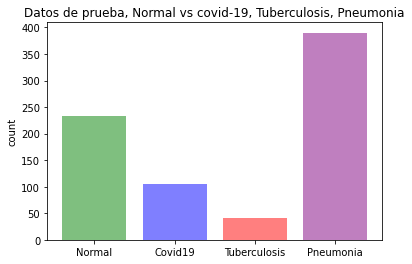

In [16]:
plt.bar([1, 2, 3, 4], np.array([len(list_test_n), len(list_test_c19), len(list_test_tb), len(list_test_pn)]), color=['green', 'blue', 'red', 'purple'], alpha=0.5)
plt.title('Datos de prueba, Normal vs covid-19, Tuberculosis, Pneumonia')
plt.xticks([1, 2, 3, 4], ('Normal', 'Covid19', 'Tuberculosis', "Pneumonia"))
plt.ylabel('count')

dic = {'Porcentaje':np.array([len(list_test_n), len(list_test_c19), len(list_test_tb), len(list_test_pn)])/sum([len(list_test_n), len(list_test_c19), len(list_test_tb), len(list_test_pn)]), 'Tipo de dato':['Normal', 'Covid 19', 'Tuberculosis', 'Pneumonia']}
tab = pd.DataFrame(dic)
tab

,Porcentaje,Tipo de dato
0,0.25,Normal
1,0.25,Covid 19
2,0.25,Tuberculosis
3,0.25,Pneumonia


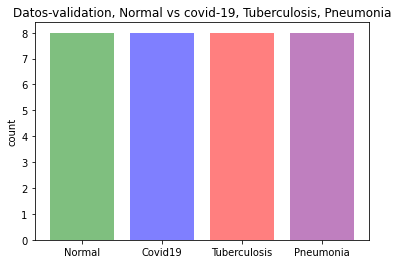

In [17]:
plt.bar([1, 2, 3, 4], np.array([len(list_val_n), len(list_val_c19), len(list_val_tb), len(list_val_pn)]), color=['green', 'blue', 'red', 'purple'], alpha=0.5)
plt.title('Datos-validation, Normal vs covid-19, Tuberculosis, Pneumonia')
plt.xticks([1, 2, 3, 4], ('Normal', 'Covid19', 'Tuberculosis', "Pneumonia"))
plt.ylabel('count')

dic = {'Porcentaje':np.array([len(list_val_n), len(list_val_c19), len(list_val_tb), len(list_val_pn)])/sum([len(list_val_n), len(list_val_c19), len(list_val_tb), len(list_val_pn)]), 'Tipo de dato':['Normal', 'Covid 19', 'Tuberculosis', 'Pneumonia']}
tab = pd.DataFrame(dic)
tab

#### Se puede ver claramente un desbalance en la cantidad de las imagenes de entrenamiento y las de testeo, unas tienen mas y otras menos, por facilidad, se hará uso de una técnica que se llama downsampling, el cual consiste en tomar de forma aleatoria imagenes del conjunto que tiene mayor cantidad de datos, hasta que complete la misma cantidad de datos que contiene la menor de todas.

In [18]:
# datos de entrenamiento
train_new_pn = train_pn_dir
train_files_pn = os.listdir(train_new_pn)
train_down_pn = rn.sample(train_files_pn, len(list_train_c19))

train_new_n = train_n_dir
train_files_n = os.listdir(train_new_n)
train_down_n = rn.sample(train_files_n, len(list_train_c19))

train_new_tb = train_tb_dir
train_files_tb = os.listdir(train_new_tb)
train_down_tb = rn.sample(train_files_tb, len(list_train_c19))

# Datos de prueba (test)

test_new_pn = test_pn_dir
test_files_pn = os.listdir(test_new_pn)
test_down_pn = rn.sample(test_files_pn, len(list_test_tb))

test_new_n = test_n_dir
test_files_n = os.listdir(test_new_n)
test_down_n = rn.sample(test_files_n, len(list_test_tb))

test_new_c19 = test_c19_dir
test_files_c19 = os.listdir(test_new_c19)
test_down_c19 = rn.sample(test_files_c19, len(list_test_tb))

# creando las carpetas

os.chdir(data_dir)
os.mkdir('train_down')
os.mkdir('test_down')
train_down_dir = os.path.join(data_dir, 'train_down')
test_down_dir = os.path.join(data_dir, 'test_down')

os.chdir(train_down_dir)
os.mkdir('NORMAL')
os.mkdir('COVID19')
os.mkdir('PNEUMONIA')
os.mkdir('TURBERCULOSIS')

os.chdir(test_down_dir)
os.mkdir('NORMAL')
os.mkdir('COVID19')
os.mkdir('PNEUMONIA')
os.mkdir('TURBERCULOSIS')

# train
train_pn_down_dir = os.path.join(train_down_dir, 'PNEUMONIA')
os.chdir(train_pn_dir)
for i in train_down_pn:
    shutil.copy(i, train_pn_down_dir)

train_n_down_dir = os.path.join(train_down_dir, 'NORMAL')
os.chdir(train_n_dir)
for i in train_down_n:
    shutil.copy(i, train_n_down_dir)
    
train_tb_down_dir = os.path.join(train_down_dir, 'TURBERCULOSIS')
os.chdir(train_tb_dir)
for i in train_down_tb:
    shutil.copy(i, train_tb_down_dir)

train_c19_down_dir = os.path.join(train_down_dir, 'COVID19')
os.chdir(train_c19_dir)
for i in list_train_c19:
    shutil.copy(i, train_c19_down_dir)    


# test
test_pn_down_dir = os.path.join(test_down_dir, 'PNEUMONIA')
os.chdir(test_pn_dir)
for i in test_down_pn:
    shutil.copy(i,test_pn_down_dir)

test_n_down_dir = os.path.join(test_down_dir, 'NORMAL')
os.chdir(test_n_dir)
for i in test_down_n:
    shutil.copy(i, test_n_down_dir)

test_c19_down_dir = os.path.join(test_down_dir, 'COVID19')
os.chdir(test_c19_dir)
for i in test_down_c19:
    shutil.copy(i, test_c19_down_dir)    

test_tb_down_dir = os.path.join(test_down_dir, 'TURBERCULOSIS')
os.chdir(test_tb_dir)
for i in list_test_tb:
    shutil.copy(i, test_tb_down_dir)

In [19]:
# Listando los nombres de los archivos para imagenes en las distintas carpetas, train, test, validation
# train
listd_train_n = os.listdir(train_n_down_dir)
listd_train_c19 = os.listdir(train_c19_down_dir)
listd_train_tb = os.listdir(train_tb_down_dir)
listd_train_pn = os.listdir(train_pn_down_dir)

#test
listd_test_n = os.listdir(test_n_down_dir)
listd_test_c19 = os.listdir(test_c19_down_dir)
listd_test_tb = os.listdir(test_tb_down_dir)
listd_test_pn = os.listdir(test_pn_down_dir)

### Validando

,Porcentaje,Tipo de dato
0,0.25,Normal
1,0.25,Covid 19
2,0.25,Tuberculosis
3,0.25,Pneumonia


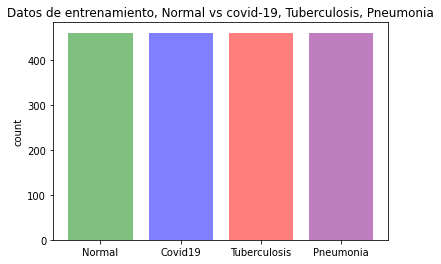

In [20]:
plt.bar([1, 2, 3, 4], np.array([len(listd_train_n), len(listd_train_c19), len(listd_train_tb), len(listd_train_pn)]), color=['green', 'blue', 'red', 'purple'], alpha=0.5)
plt.title('Datos de entrenamiento, Normal vs covid-19, Tuberculosis, Pneumonia')
plt.xticks([1, 2, 3, 4], ('Normal', 'Covid19', 'Tuberculosis', "Pneumonia"))
plt.ylabel('count')

dic = {'Porcentaje':np.array([len(listd_train_n), len(listd_train_c19), len(listd_train_tb), len(listd_train_pn)])/sum([len(listd_train_n), len(listd_train_c19), len(listd_train_tb), len(listd_train_pn)]), 'Tipo de dato':['Normal', 'Covid 19', 'Tuberculosis', 'Pneumonia']}
tab = pd.DataFrame(dic)
tab

,Porcentaje,Tipo de dato
0,0.25,Normal
1,0.25,Covid 19
2,0.25,Tuberculosis
3,0.25,Pneumonia


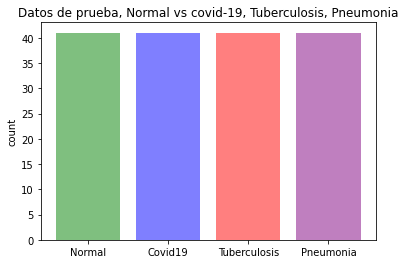

In [21]:
plt.bar([1, 2, 3, 4], np.array([len(listd_test_n), len(listd_test_c19), len(listd_test_tb), len(listd_test_pn)]), color=['green', 'blue', 'red', 'purple'], alpha=0.5)
plt.title('Datos de prueba, Normal vs covid-19, Tuberculosis, Pneumonia')
plt.xticks([1, 2, 3, 4], ('Normal', 'Covid19', 'Tuberculosis', "Pneumonia"))
plt.ylabel('count')

dic = {'Porcentaje':np.array([len(listd_test_n), len(listd_test_c19), len(listd_test_tb), len(listd_test_pn)])/sum([len(listd_test_n), len(listd_test_c19), len(listd_test_tb), len(listd_test_pn)]), 'Tipo de dato':['Normal', 'Covid 19', 'Tuberculosis', 'Pneumonia']}
tab = pd.DataFrame(dic)
tab

#### Con los datos balanceados, se procede a visualizar las imagenes:

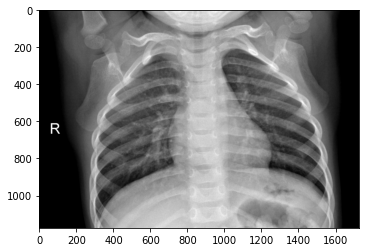

In [22]:
gamma = 3
filename = train_n_dir + '/' + str(list_train_n[1])
img = cv2.imread(filename)
c_image = np.power(img, gamma)
plt.imshow(img)

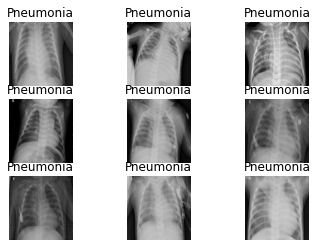

In [23]:
for i in range(9):
    plt.subplot(330 + 1 + i)
    filename = train_pn_dir + '/' + str(list_train_pn[i])
    img = cv2.imread(filename)
    img = cv2.resize(img, (200, 200))
    plt.title('Pneumonia')
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.show()


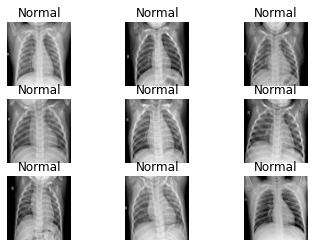

In [24]:
for i in range(9):
    plt.subplot(330 + 1 + i)
    filename = train_n_dir + '/' + str(list_train_n[i])
    img = cv2.imread(filename)
    img = cv2.resize(img, (200, 200))
    plt.title('Normal')
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.show()

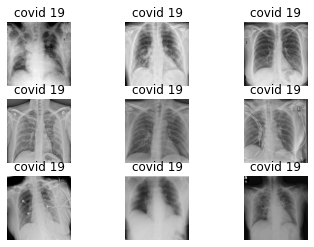

In [25]:
for i in range(9):
    plt.subplot(330 + 1 + i)
    filename = train_c19_dir + '/' + str(list_train_c19[i])
    img = cv2.imread(filename)
    img = cv2.resize(img, (200, 200))
    plt.title('covid 19')
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.show()

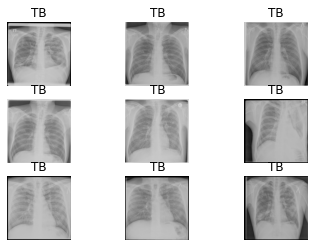

In [26]:
for i in range(9):
    plt.subplot(330 + 1 + i)
    filename = train_tb_dir + '/' + str(list_train_tb[i])
    img = cv2.imread(filename)
    img = cv2.resize(img, (200, 200))
    plt.title('TB')
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.show()

### Creando el modelo:

In [27]:
#train
datagen_train = ImageDataGenerator(rescale=1.0/255.0, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15, fill_mode='nearest', zoom_range=0.2, brightness_range=[0.9, 1.1])
#test
datagen_test = ImageDataGenerator(rescale=0.1/255.0)
#validation 
datagen_val = ImageDataGenerator(rescale=1.0/255.0)

train_it = datagen_train.flow_from_directory(train_down_dir, class_mode='categorical', batch_size=65, shuffle=True, target_size=(224, 224), color_mode="rgb", seed=42)
test_it = datagen_test.flow_from_directory(test_down_dir, class_mode='categorical', batch_size=65, shuffle=True, target_size=(224, 224), color_mode="rgb", seed=42)
val_it = datagen_val.flow_from_directory(val_dir, batch_size=1, class_mode=None, shuffle=False, target_size=(224, 224), color_mode="rgb", seed=44)

Found 1840 images belonging to 4 classes.
Found 164 images belonging to 4 classes.
Found 32 images belonging to 4 classes.


### Arquitectura del modelo: VGG16

In [28]:
conv_01 = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
print(conv_01.summary())

58900480/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [29]:
model_01 = Sequential()
model_01.add(conv_01)
model_01.add(Flatten())
model_01.add(Dropout(0.2))
model_01.add(Dense(200, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_01.add(Dropout(0.2))
model_01.add(Dense(4, activation='softmax'))
model_01.compile(optimizer=Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics=['accuracy'])
print("Compilando modelo")
print(model_01.summary())

Compilando modelo
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 200)               5017800   
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 804       
                                                                 
Total params: 19,733,292
Trainable par

#### Lo que se busca es ajustar el learning rate de manera dinamica durante el entrenamiento, esto es para disminuir cada vez que el loss no muestre una mejora. 

In [30]:
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='auto', min_lr=0.000001)
earlyn_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
model_check = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto')

### Entrenando el modelo:

In [31]:
history = model_01.fit(train_it, 
epochs=60,
steps_per_epoch=train_it.n//train_it.batch_size, 
validation_data=test_it, 
validation_steps=test_it.n//test_it.batch_size,
callbacks=[rlr, earlyn_stop, model_check])

Epoch 1/60
28/28 [==============================] - ETA: 0s - loss: 1.2953 - accuracy: 0.6039
Epoch 00001: val_loss improved from inf to 2.58630, saving model to weights.h5
28/28 [==============================] - 126s 3s/step - loss: 1.2953 - accuracy: 0.6039 - val_loss: 2.5863 - val_accuracy: 0.2769 - lr: 1.0000e-04
Epoch 2/60
28/28 [==============================] - ETA: 0s - loss: 0.7861 - accuracy: 0.8096
Epoch 00002: val_loss improved from 2.58630 to 2.22843, saving model to weights.h5
28/28 [==============================] - 84s 3s/step - loss: 0.7861 - accuracy: 0.8096 - val_loss: 2.2284 - val_accuracy: 0.2615 - lr: 1.0000e-04
Epoch 3/60
28/28 [==============================] - ETA: 0s - loss: 0.5843 - accuracy: 0.8851
Epoch 00003: val_loss did not improve from 2.22843
28/28 [==============================] - 84s 3s/step - loss: 0.5843 - accuracy: 0.8851 - val_loss: 2.3383 - val_accuracy: 0.2615 - lr: 1.0000e-04
Epoch 4/60
28/28 [==============================] - ETA: 0s - loss

### Cargando los pesos: 

In [32]:
model_01.load_weights('weights.h5')
model_01.save('Clasificacion_x_ray_cnn.h5')

### Validando el modelo:

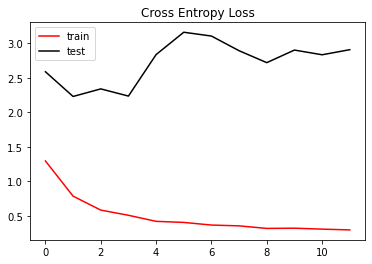

None


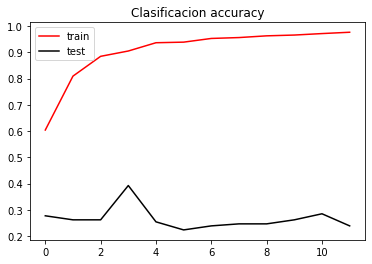

None


In [35]:
def summarize_diagnostics_loss(history):
  # grafico de loss
  plt.title('Cross Entropy Loss')
  plt.plot(history.history['loss'], color='red', label='train')
  plt.plot(history.history['val_loss'], color='black', label='test')
  plt.legend(loc=2)
  plt.show()
  plt.close()

def summarize_diagnostics_acc(history):
  # grafico de la presicion
  plt.title('Clasificacion accuracy')
  plt.plot(history.history['accuracy'], color='red', label='train')
  plt.plot(history.history['val_accuracy'], color='black', label='test')
  plt.legend(loc=2)
  plt.show()
  plt.close()

print(summarize_diagnostics_loss(history))
print(summarize_diagnostics_acc(history))

### Validando el modelo:

In [66]:
val_it.reset()

# haciendo una predicción
pred = model_01.predict_generator(val_it, steps=val_it.n, verbose=1)

# Optando por la clase de la predicción de probabilidad:
pre_class_indice = np.argmax(pred, axis=1)

# Creando etiquetas:
etiqueta = val_it.class_indices
etiqueta = dict((i, j) for i, j in etiqueta.items())
dic_pred = []
for k in pre_class_indice:
  dic_pred.append(k)

print(f"valores para leer la tabla: {etiqueta}")
# Mostrando los resultados:
filenames = val_it.filenames
result = pd.DataFrame({'File name': filenames, 'Predicción':dic_pred})
result 

#print(filenames)

 1/32 [..............................] - ETA: 2s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.


32/32 [==============================] - 1s 37ms/step
valores para leer la tabla: {'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2, 'TURBERCULOSIS': 3}


,File name,Predicción
0,COVID19/COVID19(566).jpg,0
1,COVID19/COVID19(567).jpg,0
2,COVID19/COVID19(568).jpg,0
3,COVID19/COVID19(571).jpg,0
4,COVID19/COVID19(572).jpg,0
5,COVID19/COVID19(573).jpg,0
6,COVID19/COVID19(574).jpg,0
7,COVID19/COVID19(575).jpg,0
8,NORMAL/NORMAL2-IM-1427-0001.jpeg,1
9,NORMAL/NORMAL2-IM-1430-0001.jpeg,1
